# Determining Feature Significance with Machine Learning help.
Let's say you have a theory that certain features hold the potential to predict market prices. One method to validate or refute it is by leveraging machine learning methods. By employing such techniques, you can effectively assess the predictive power of these features and gain insights into their significance in determining market prices.
In this example I will be using Logistic Regression, Random Forest Classification and Gradient Boosting Classification.

Let's start.


In [22]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import talib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# load 1min data
df = pd.read_csv('crypto_2023_upto_May8.csv')

df.head()

,time,open,high,low,close,volume,dir,dist,x_open,x_high,x_low,x_close,x_dir,x_dist
0,2023-01-01 00:00:00,0.7578,0.7579,0.7573,0.7575,29643,-1,0.0006,-0.000010,-0.000010,-0.000397,-0.000194,-1,0.000386
1,2023-01-01 00:01:00,0.7578,0.7579,0.7574,0.7575,2377,-1,0.0005,0.000083,0.000083,-0.000456,-0.000298,-1,0.000539
2,2023-01-01 00:02:00,0.7573,0.7574,0.7568,0.7568,4221,-1,0.0006,-0.000348,-0.000189,-0.000485,-0.000485,-1,0.000296
3,2023-01-01 00:03:00,0.7568,0.7569,0.7566,0.7566,4470,-1,0.0003,-0.000535,-0.000447,-0.000592,-0.000592,-1,0.000145
4,2023-01-01 00:04:00,0.7565,0.7565,0.7556,0.7562,15390,-1,0.0009,-0.000537,0.000000,-0.000537,0.000000,1,0.000537


### Correlation check
Will check target features correlation first. To see how they compare to each other.

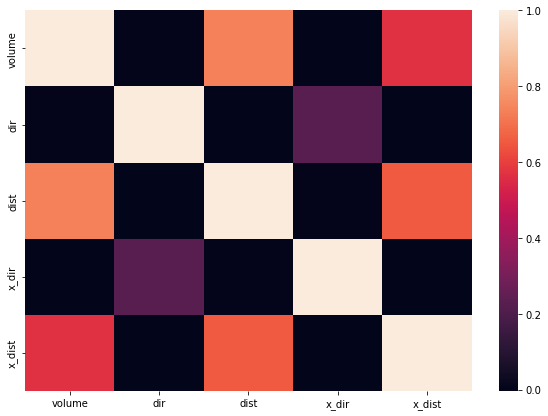

In [7]:
# Create feature dataframe X with feature columns and dummy variables for categorical features
features = ['volume', 'dir', 'dist', 'x_dir', 'x_dist']
C = pd.get_dummies(df[features], drop_first=True)

# plot correlation heatmap
plt.figure(figsize = (10,7))
sns.heatmap(C.corr())
plt.show()
plt.close()

### Distribution check
In order to apply Logistic Regression model have to make sure that our data is normaly distributed.

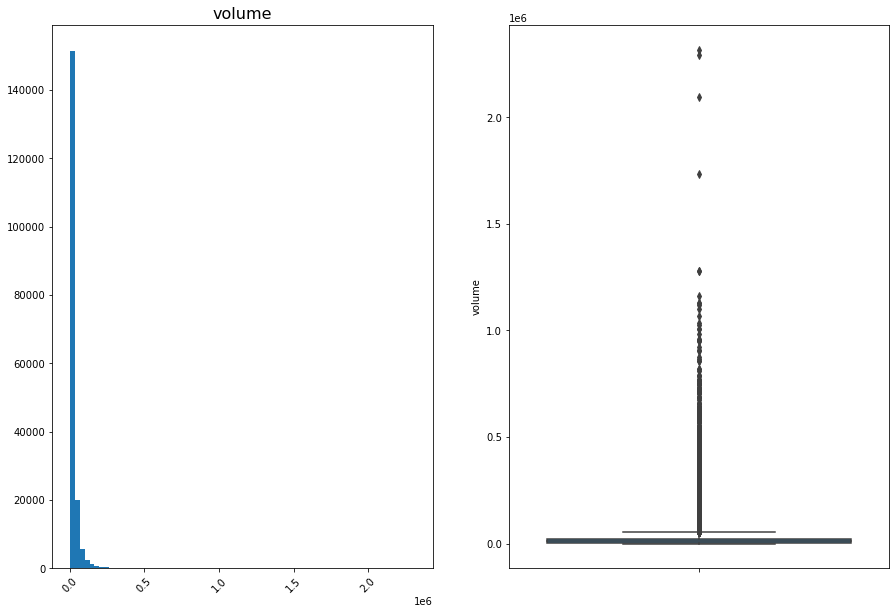

2 2317504


<Figure size 432x288 with 0 Axes>

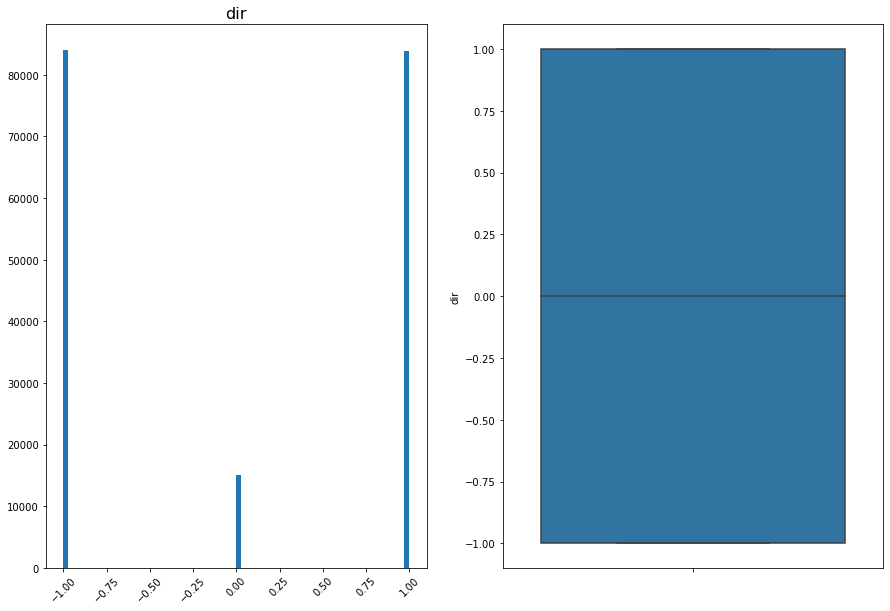

-1 1


<Figure size 432x288 with 0 Axes>

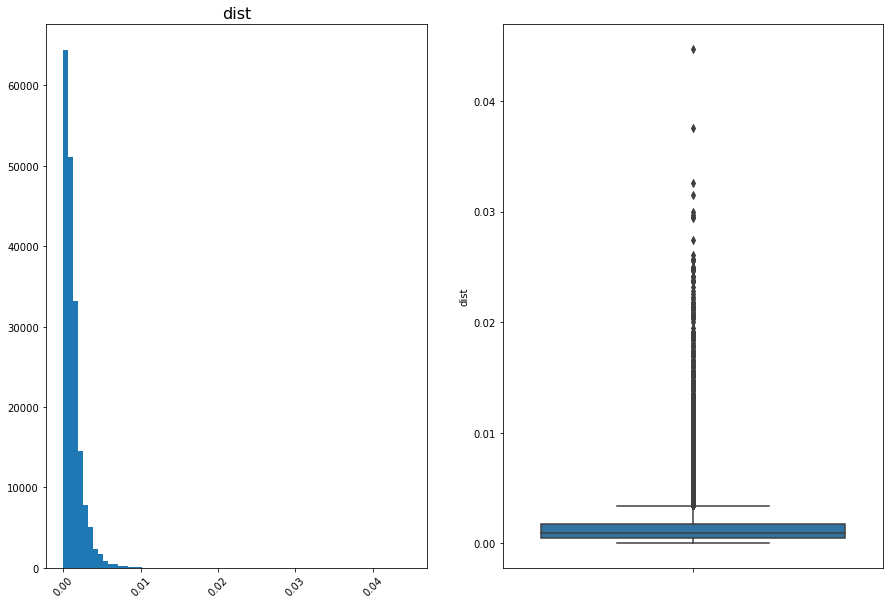

0.0 0.0447


<Figure size 432x288 with 0 Axes>

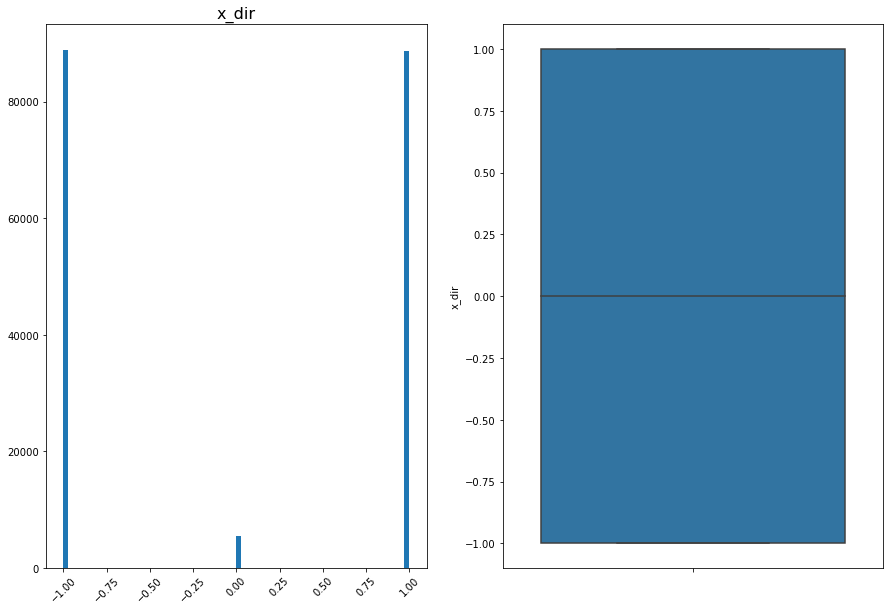

-1 1


<Figure size 432x288 with 0 Axes>

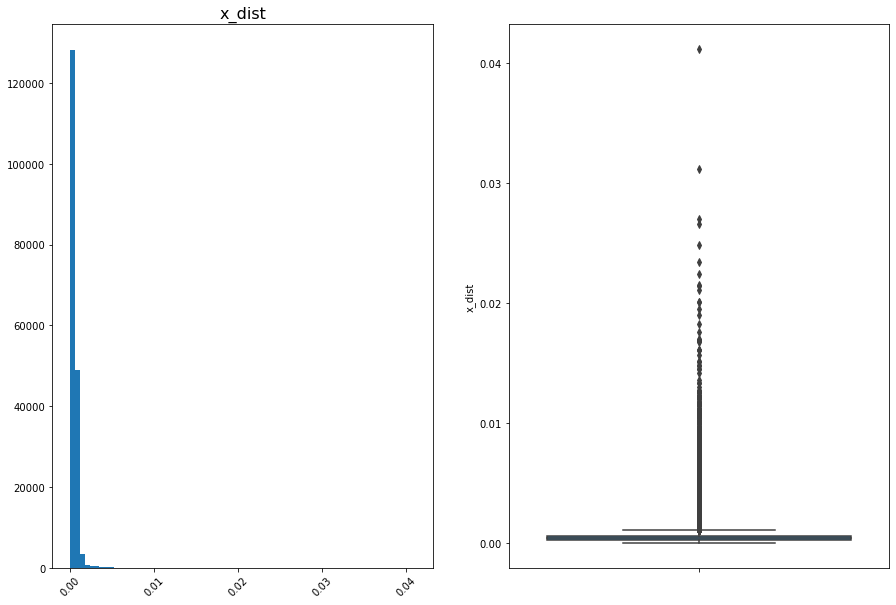

0.0 0.04117314


<Figure size 432x288 with 0 Axes>

In [8]:
# Check for distribution

# Features dataframe
D = df[features]
# Loop over column names
for i in D.columns:
    feature = D[i]
    plt.figure(figsize=(15, 10))
    # Plot histogram to spot distribution
    plt.subplot(1,2,1)
    plt.hist(feature, bins=70)
    plt.xticks(rotation=45)
    plt.title(i, size=16)
    # Plot boxplot to spot outliers
    plt.subplot(1,2,2)
    sns.boxplot(y=feature)
    plt.show()
    plt.clf()
    print(feature.min(), feature.max())

#### Since some features are not normally distributed we need to log transform them

In [9]:
# Adding constant value for those features that have zero value so it would not produce error
df['dist'] = df['dist'] + 1
df['x_dist'] = df['x_dist'] + 1

In [10]:
# Log-Transform feature list
ft_to_log = ['volume', 'dist', 'x_dist' ]
# Apply log transformation to the selected features
df[ft_to_log] = np.log(df[ft_to_log])

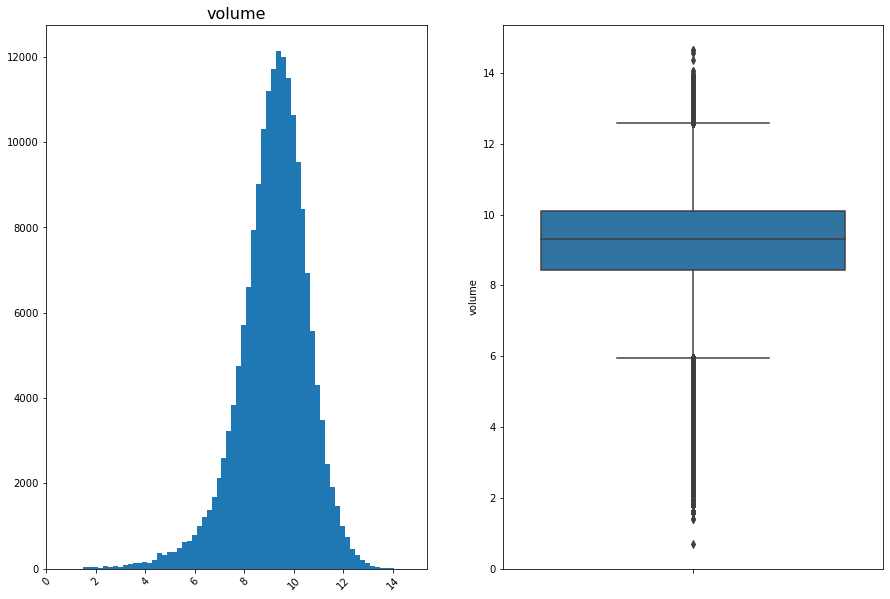

0.6931471805599453 14.6560013024185


<Figure size 432x288 with 0 Axes>

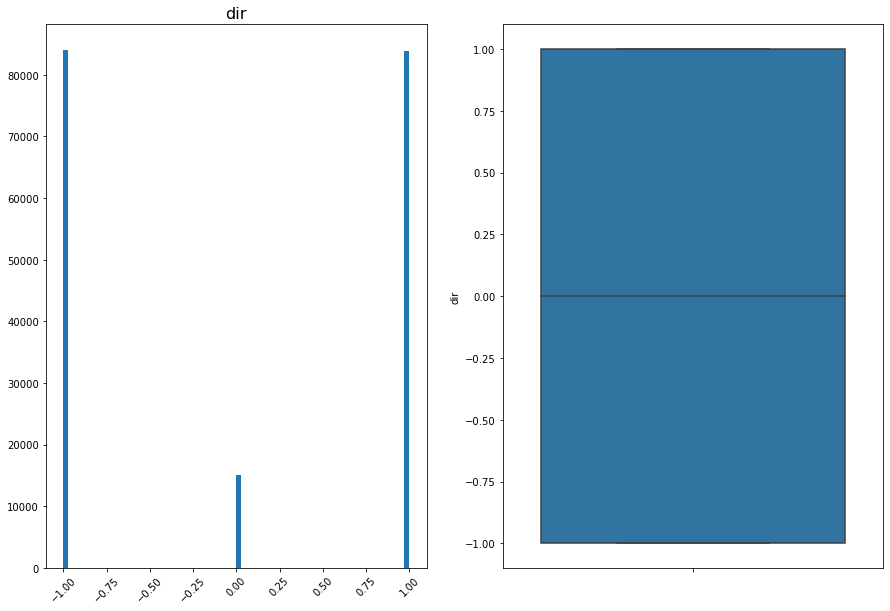

-1 1


<Figure size 432x288 with 0 Axes>

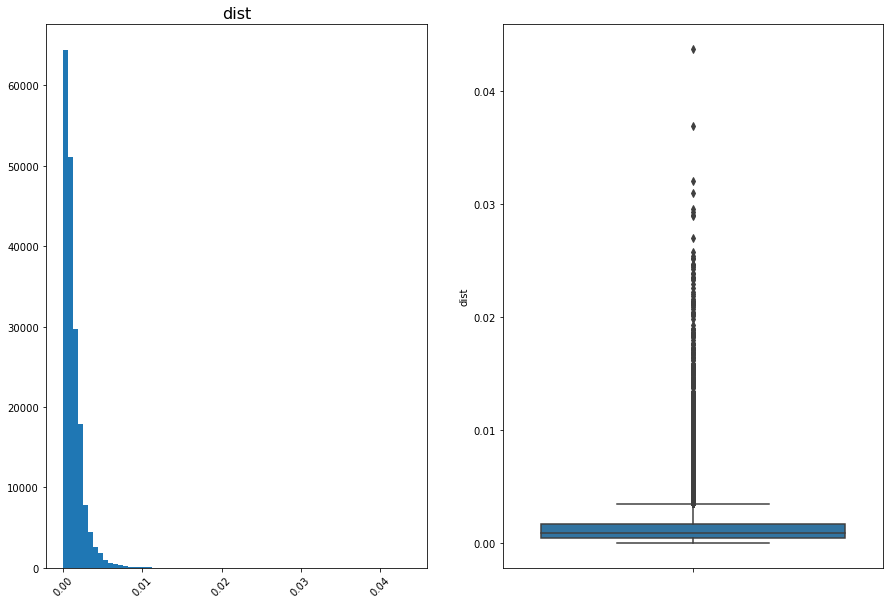

0.0 0.0437297628613252


<Figure size 432x288 with 0 Axes>

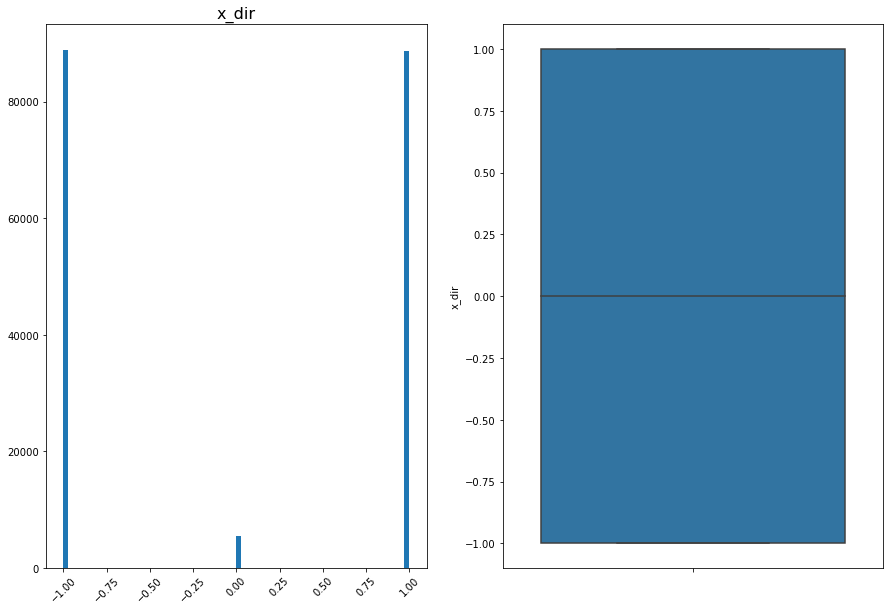

-1 1


<Figure size 432x288 with 0 Axes>

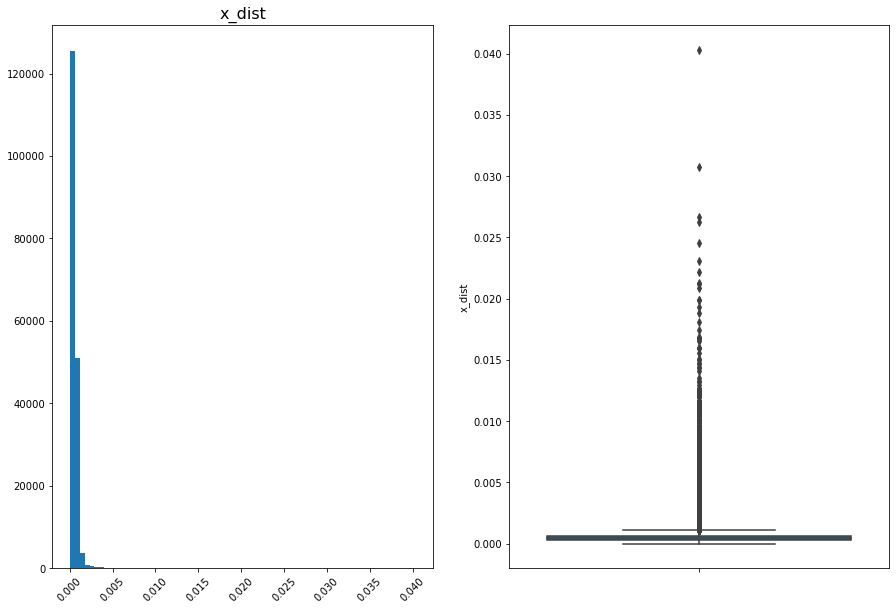

0.0 0.04034809664839443


<Figure size 432x288 with 0 Axes>

In [11]:
# Check for distribution
# Features dataframe
D = df[features]
# Loop over column names
for i in D.columns:
    feature = D[i]
    plt.figure(figsize=(15, 10))
    # Plot histogram to spot distribution
    plt.subplot(1,2,1)
    plt.hist(feature, bins=70)
    plt.xticks(rotation=45)
    plt.title(i, size=16)
    # Plot boxplot to spot outliers
    plt.subplot(1,2,2)
    sns.boxplot(y=feature)
    plt.show()
    plt.clf()
    print(feature.min(), feature.max())

Logarithmic transformation worked well on volume but did not do much on dist and x_dist

### Scale data
Bringing testing data onto same scale.

In [12]:
# Scale the data

# Instantiate standard scaler
scaler = StandardScaler()
# Fit transform data
cols_to_scale = ['volume', 'dist', 'x_dist']
array_nums_scaled = scaler.fit_transform(df[cols_to_scale])
# Creating scaled df
scaled = pd.DataFrame(array_nums_scaled, columns=cols_to_scale)
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaled[cols_to_scale]
df_scaled.head()

,time,open,high,low,close,volume,dir,dist,x_open,x_high,x_low,x_close,x_dir,x_dist
0,2023-01-01 00:00:00,0.7578,0.7579,0.7573,0.7575,0.789009,-1,-0.514453,-0.000010,-0.000010,-0.000397,-0.000194,-1,-0.255006
1,2023-01-01 00:01:00,0.7578,0.7579,0.7574,0.7575,-0.999133,-1,-0.591500,0.000083,0.000083,-0.000456,-0.000298,-1,0.010510
2,2023-01-01 00:02:00,0.7573,0.7574,0.7568,0.7568,-0.592216,-1,-0.514453,-0.000348,-0.000189,-0.000485,-0.000485,-1,-0.412599
3,2023-01-01 00:03:00,0.7568,0.7569,0.7566,0.7566,-0.551600,-1,-0.745618,-0.000535,-0.000447,-0.000592,-0.000592,-1,-0.674994
4,2023-01-01 00:04:00,0.7565,0.7565,0.7556,0.7562,0.324498,-1,-0.283356,-0.000537,0.000000,-0.000537,0.000000,1,0.008248


### Split data into test and train dataset
Will split data into two parts. Train data which will be 80% of data and test data 20 of data.

In [13]:
# Split data into test and train dataset

# Select predictors
X = df_scaled[['volume', 'dist', 'x_dir', 'x_dist']]
# Select target variable
y = df_scaled['dir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2)

### Fit Logistic Regression model

In [14]:
# Fit LR model with sklearn on train set, and predicting on the test set
log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Print model parameters and coefficients
print('Model Parameters, Intercept:', log_reg.intercept_)

print('Model Parameters, Coeff:', log_reg.coef_)

Model Parameters, Intercept: [-0.17509754 -3.93080215 -0.17766669]
Model Parameters, Coeff: [[ 1.80908655e-01  1.72512606e-02 -4.59759926e-01 -1.30623792e-02]
 [-3.20787491e-01 -3.21322081e+00 -1.48926315e-03  4.59817914e-01]
 [ 1.79005588e-01  2.71556025e-02  4.60028529e-01 -3.19953249e-02]]


In [15]:
# Print out the confusion matrix
print("Confusion matrix: ")
print(confusion_matrix(y_test,y_pred))

# Print out model accuracy
print("Accuracy score: ", accuracy_score(y_test, y_pred))

Confusion matrix: 
[[10265    38  6506]
 [ 1266   387  1262]
 [ 6229    27 10611]]
Accuracy score:  0.581099177393348


In [17]:
# Create new DataFrame of the model coefficients and variable names; sort values based on coefficient
mod_coef = pd.DataFrame(zip(X_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
mod_coef = mod_coef[mod_coef.coef.abs()>0].sort_values('coef')
print(mod_coef)
print("Generally the higher the coefficient amplitude is the more affect it has on the prediction")

      var      coef
2   x_dir -0.459760
3  x_dist -0.013062
1    dist  0.017251
0  volume  0.180909
Generally the higher the coefficient amplitude is the more affect it has on the prediction


### Random Forest Classification
Will use this model to sort out features that have higher impact on the prediction.

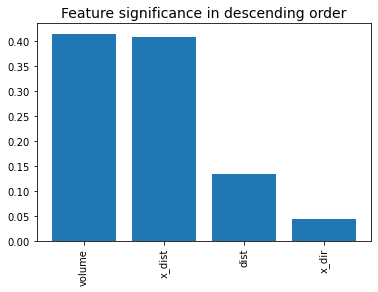

In [20]:
# fit rfc model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# get feature importances and sort in descending order
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

# plot feature importances
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature significance in descending order", fontsize=14)
plt.show()


### Gradient Boosting Classification
Will run gradient boosting classification model and plot partial dependence graph for two features with highest impact to see if there is a visible pattern.

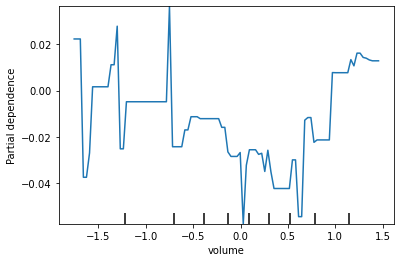

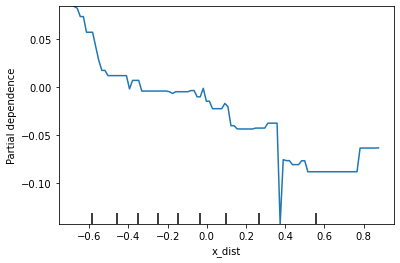

In [23]:
# fit gbc model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# plot partial dependence plot for volume
plot_partial_dependence(gb, X_train, [0], target=1)
# plot partial dependence plot for x_dist
plot_partial_dependence(gb, X_train, [3], target=1)

On the chart above Y axis is the predicted probability of the target class. X axis is the target class values. Positive values of Y asix suggest an increasing effect, while negative values suggest a decreasing effect. Volume values do not produce visible pattern, however x_dist does show visible pattern. 

### Changing target feature "dir" instead of -1,0,1 to  binary option up or down. And if open=close will take previous value.

In [24]:
# Create a new column binary_dir with two way classification
df_scaled['binary_dir'] = df_scaled['dir'].apply(lambda x: 1 if x == 1 else 0 if x == -1 else None)
df_scaled['binary_dir'] = df_scaled['binary_dir'].fillna(method='ffill').astype(int)

#### Repeat all models just now for binary target

In [25]:
# Select predictors
X = df_scaled[['volume', 'dist', 'x_dir', 'x_dist']]
# Select target variable
y = df_scaled['binary_dir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2)

In [26]:
# Fit LR model with sklearn on train set, and predicting on the test set
log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Print model parameters and coefficients
print('Model Parameters, Intercept:', log_reg.intercept_)

print('Model Parameters, Coeff:', log_reg.coef_)

Model Parameters, Intercept: [0.00275957]
Model Parameters, Coeff: [[-0.00570091  0.00156979  0.42645596 -0.00778554]]


In [27]:
# Print out the confusion matrix
print("Confusion matrix: ")
print(confusion_matrix(y_test,y_pred))

# Print out accuracy
print("Accuracy score: ", accuracy_score(y_test, y_pred))

Confusion matrix: 
[[10882  7443]
 [ 7015 11251]]
Accuracy score:  0.6048755158372278


In [28]:
# Create new DataFrame of the model coefficients and variable names; sort values based on coefficient
mod_coef = pd.DataFrame(zip(X_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
mod_coef = mod_coef[mod_coef.coef.abs()>0].sort_values('coef')
print(mod_coef)

      var      coef
3  x_dist -0.007786
0  volume -0.005701
1    dist  0.001570
2   x_dir  0.426456


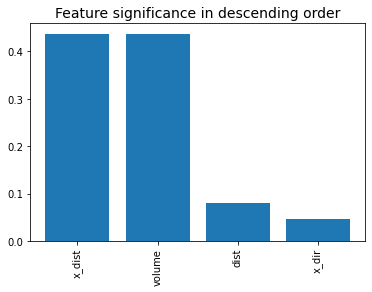

In [29]:
# fit rfc model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# get feature importances and sort in descending order
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

# plot feature importances
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature significance in descending order", fontsize=14)
plt.show()


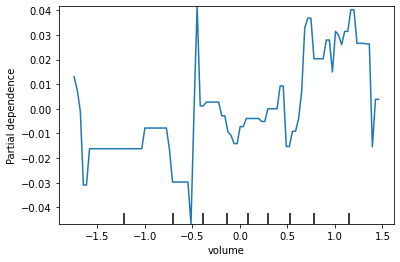

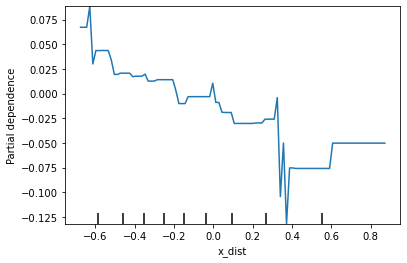

In [30]:
# fit gbc model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# plot partial dependence plot for volume
plot_partial_dependence(gb, X_train, [0], target=1)
# plot partial dependence plot for x_dist
plot_partial_dependence(gb, X_train, [3], target=1)

Again x_dist shows more clear pattern.

# Let's add simplified version of the recent trend as our feature
Will compare current price value with the value of 10 min ago and give it a classification. Up 1, Down -1, Sideways 0.

In [31]:
# shift close price compare it and place its value into classification equasion
df_scaled['ten_dir'] = np.where(df_scaled['close'] > df_scaled['close'].shift(10), 1,
                 np.where(df_scaled['close'] < df_scaled['close'].shift(10), -1, 0))

In [32]:
ten = df_scaled[10:]
ten.head()

,time,open,high,low,close,volume,dir,dist,x_open,x_high,x_low,x_close,x_dir,x_dist,binary_dir,ten_dir
10,2023-01-01 00:10:00,0.7546,0.7552,0.7546,0.7547,0.125868,1,-0.514453,-0.000327,-9.000000e-08,-0.000535,-0.000535,-1,0.003291,1,-1
11,2023-01-01 00:11:00,0.7547,0.7547,0.7545,0.7545,-0.321137,-1,-0.822689,-0.000527,-2.765800e-04,-0.000532,-0.000299,1,-0.482509,0,-1
12,2023-01-01 00:12:00,0.7546,0.7546,0.7540,0.7542,0.633348,-1,-0.514453,-0.000253,-2.176200e-04,-0.000504,-0.000456,-1,-0.428031,0,-1
13,2023-01-01 00:13:00,0.7540,0.7541,0.7540,0.7541,-0.849706,1,-0.899767,-0.000346,-1.763000e-04,-0.000469,-0.000348,-1,-0.417157,1,-1
14,2023-01-01 00:14:00,0.7541,0.7542,0.7537,0.7537,-0.198612,-1,-0.591500,-0.000116,-1.052900e-04,-0.000481,-0.000481,-1,-0.273569,0,-1


#### Repeat all models with trend feature

In [33]:
# Select predictors
X = ten[['volume', 'dist', 'x_dir', 'x_dist', 'ten_dir']]
# Select target variable
y = ten['dir']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2)

In [34]:
# Fit LR model with sklearn on train set, and predicting on the test set
log_reg = LogisticRegression(C=0.05, penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Print model parameters and coefficients
print('Model Parameters, Intercept:', log_reg.intercept_)

print('Model Parameters, Coeff:', log_reg.coef_)

Model Parameters, Intercept: [-0.17979457 -3.89414617 -0.185262  ]
Model Parameters, Coeff: [[ 0.1894176   0.01416193 -0.48358169 -0.02609769 -0.42928512]
 [-0.3258794  -3.14290757 -0.00361794  0.46359101  0.        ]
 [ 0.18005972  0.03297674  0.48438642 -0.0217966   0.42431463]]


In [35]:
# Print out the confusion matrix
print("Confusion matrix: ")
print(confusion_matrix(y_test,y_pred))

# Print out accuracy
print("Accuracy score: ", accuracy_score(y_test, y_pred))

Confusion matrix: 
[[10302    80  6403]
 [ 1266   466  1284]
 [ 6219    59 10510]]
Accuracy score:  0.5815409002705731


In [36]:
# Create new DataFrame of the model coefficients and variable names; sort values based on coefficient
mod_coef = pd.DataFrame(zip(X_train.columns, log_reg.coef_[0]), columns=['var', 'coef']).sort_values('coef')
mod_coef = mod_coef[mod_coef.coef.abs()>0].sort_values('coef')
print(mod_coef)

       var      coef
2    x_dir -0.483582
4  ten_dir -0.429285
3   x_dist -0.026098
1     dist  0.014162
0   volume  0.189418


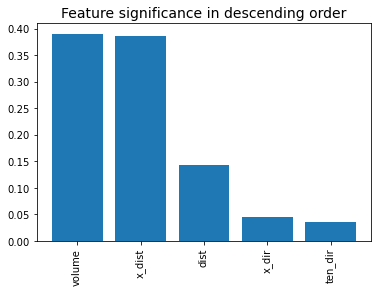

In [37]:
# fit rfc model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# get feature importances and sort in descending order
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

# plot feature importances
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature significance in descending order", fontsize=14)
plt.show()


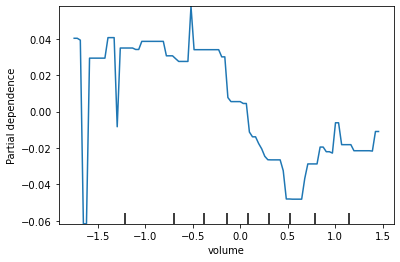

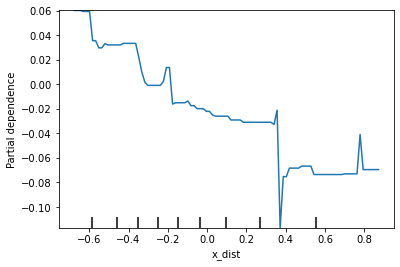

In [38]:
# fit gbc model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# plot partial dependence plot for volume
plot_partial_dependence(gb, X_train, [0], target=1)
# plot partial dependence plot for x_dist
plot_partial_dependence(gb, X_train, [3], target=1)

### Conclusion

The features that appear to have the most significant impact are Volume and x_dist. x_dist with clear visible pattern.